Importamos librerías necesarias y obtenemos las etiquetas a partir de la ruta de cada carpeta

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

def proc_img(filepath):
    """ Se crea un DataFrame con el path del fichero y su correspondiente etiqueta
    """

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Se concatenan las etiquetas y los paths
    df = pd.concat([filepath, labels], axis=1)

    # Se reinician los índices
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# Se especifica cuál es el directorio de entrenamiento
train_dir = Path('./simpsons_dataset')
filepaths = list(train_dir.glob(r'**/*.jpg'))

# Obtenemos el DataFrame con las etiquetas y los paths
df = proc_img(filepaths)

print(f'Número de imágenes: {df.shape[0]}\n')
print(f'Número de etiquetas únicas: {len(df.Label.unique())}\n')
print(f'Etiquetas: {df.Label.unique()}')

# Comprobamos que se ha hecho correctamente
df.head(5)

Número de imágenes: 19548

Número de etiquetas únicas: 20

Etiquetas: ['krusty_the_clown' 'milhouse_van_houten' 'apu_nahasapeemapetilon'
 'homer_simpson' 'principal_skinner' 'chief_wiggum' 'moe_szyslak'
 'edna_krabappel' 'charles_montgomery_burns' 'abraham_grampa_simpson'
 'bart_simpson' 'sideshow_bob' 'nelson_muntz' 'marge_simpson'
 'lisa_simpson' 'ned_flanders' 'comic_book_guy' 'lenny_leonard'
 'mayor_quimby' 'kent_brockman']


,Filepath,Label
0,simpsons_dataset\krusty_the_clown\pic_0305.jpg,krusty_the_clown
1,simpsons_dataset\milhouse_van_houten\pic_0413.jpg,milhouse_van_houten
2,simpsons_dataset\apu_nahasapeemapetilon\pic_04...,apu_nahasapeemapetilon
3,simpsons_dataset\milhouse_van_houten\pic_0293.jpg,milhouse_van_houten
4,simpsons_dataset\homer_simpson\pic_0475.jpg,homer_simpson


In [2]:
#Cargamos el conjunto de prueba
test_dir = Path('./kaggle_simpson_testset/')
filepaths_test = list(test_dir.glob(r'**/*.jpg'))
df_test= proc_img(filepaths_test)
df_test.head(5)

,Filepath,Label
0,kaggle_simpson_testset\lenny_leonard\lenny_leo...,lenny_leonard
1,kaggle_simpson_testset\sideshow_bob\sideshow_b...,sideshow_bob
2,kaggle_simpson_testset\lenny_leonard\lenny_leo...,lenny_leonard
3,kaggle_simpson_testset\ned_flanders\ned_flande...,ned_flanders
4,kaggle_simpson_testset\comic_book_guy\comic_bo...,comic_book_guy


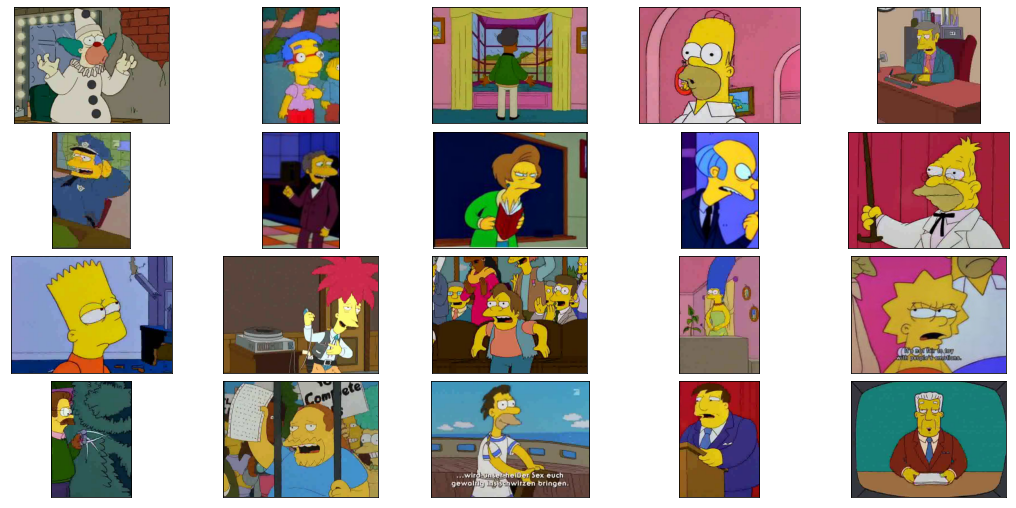

In [4]:
#Se eliminan las etiquetas duplicadas
df_unique = df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Se muestra una imagen de todos los personajes
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
plt.tight_layout(pad=0.5)
plt.show()

In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [7]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 15639 validated image filenames belonging to 20 classes.
Found 3909 validated image filenames belonging to 20 classes.
Found 990 validated image filenames belonging to 20 classes.


In [8]:
#Cargamos los modelos pre-entrenados
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB0

modelo_vgg16 = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet',pooling='avg')
modelo_inceptionv3 = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet',pooling='avg')
modelo_resnet50 = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet',pooling='avg')
modelo_efficientnetb0 = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet',pooling='avg')

modelo_vgg16.trainable = False
modelo_inceptionv3.trainable = False
modelo_resnet50.trainable = False
modelo_efficientnetb0.trainable = False

In [11]:
inputs = modelo_resnet50.input

x = tf.keras.layers.Dense(128, activation='relu')(modelo_resnet50.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(20, activation='softmax')(x)

model_resnet50 = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model_resnet50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_resnet50 = model_resnet50.fit(train_images, validation_data=val_images, epochs=10, batch_size=50, callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
])
model.summary()

Epoch 1/10
489/489 [==============================] - 1192s 2s/step - loss: 1.4722 - accuracy: 0.5676 - val_loss: 1.0480 - val_accuracy: 0.6925
Epoch 2/10
489/489 [==============================] - 1183s 2s/step - loss: 0.7522 - accuracy: 0.7788 - val_loss: 0.8369 - val_accuracy: 0.7613
Epoch 3/10
489/489 [==============================] - 1184s 2s/step - loss: 0.5533 - accuracy: 0.8382 - val_loss: 0.6964 - val_accuracy: 0.8010
Epoch 4/10
489/489 [==============================] - 1198s 2s/step - loss: 0.4451 - accuracy: 0.8669 - val_loss: 0.7076 - val_accuracy: 0.8056
Epoch 5/10
489/489 [==============================] - 1191s 2s/step - loss: 0.3687 - accuracy: 0.8870 - val_loss: 0.7218 - val_accuracy: 0.8017
Epoch 6/10
489/489 [==============================] - 1190s 2s/step - loss: 0.3046 - accuracy: 0.9052 - val_loss: 0.7031 - val_accuracy: 0.8102
Epoch 7/10
489/489 [==============================] - 1190s 2s/step - loss: 0.2546 - accuracy: 0.9205 - val_loss: 0.6697 - val_accuracy:

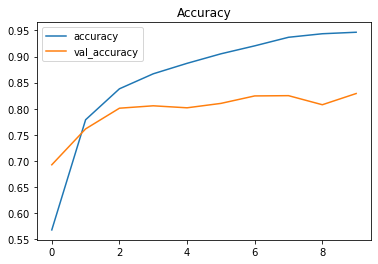

In [17]:
pd.DataFrame(history_resnet50.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

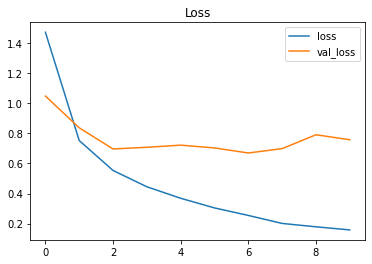

In [18]:
pd.DataFrame(history_resnet50.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [12]:
# Se hace la predicción con el conjunto de test
pred = model_resnet50.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Se muestran los resultados
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['lenny_leonard', 'sideshow_bob', 'lenny_leonard', 'homer_simpson', 'comic_book_guy']


In [13]:
from sklearn import metrics
y_test = list(df_test.Label)
acc = metrics.accuracy_score(y_test,pred)
print(f'Accuracy en el conjunto de prueba: {acc * 100:.2f}%')

Accuracy en el conjunto de prueba: 86.26%


In [14]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.85      0.94      0.89        48
  apu_nahasapeemapetilon       1.00      0.88      0.94        50
            bart_simpson       0.75      0.92      0.83        50
charles_montgomery_burns       0.73      0.85      0.79        48
            chief_wiggum       0.94      0.98      0.96        50
          comic_book_guy       0.96      0.90      0.93        49
          edna_krabappel       0.88      0.92      0.90        50
           homer_simpson       0.70      0.92      0.79        50
           kent_brockman       0.94      0.88      0.91        50
        krusty_the_clown       0.80      0.98      0.88        50
           lenny_leonard       1.00      0.36      0.53        50
            lisa_simpson       0.81      0.76      0.78        50
           marge_simpson       0.92      0.92      0.92        50
            mayor_quimby       1.00      0.82      0.90        50
     milh

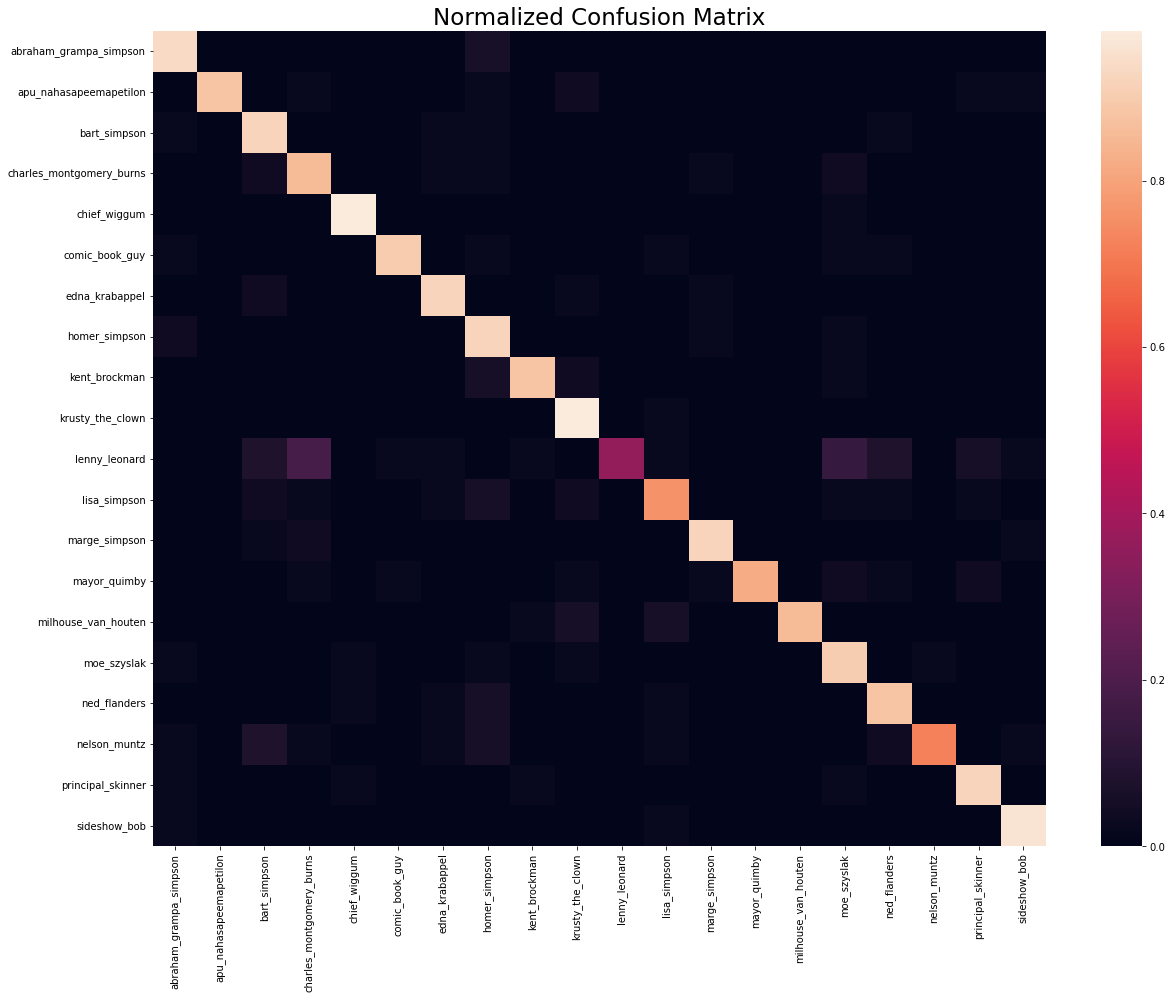

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.show()

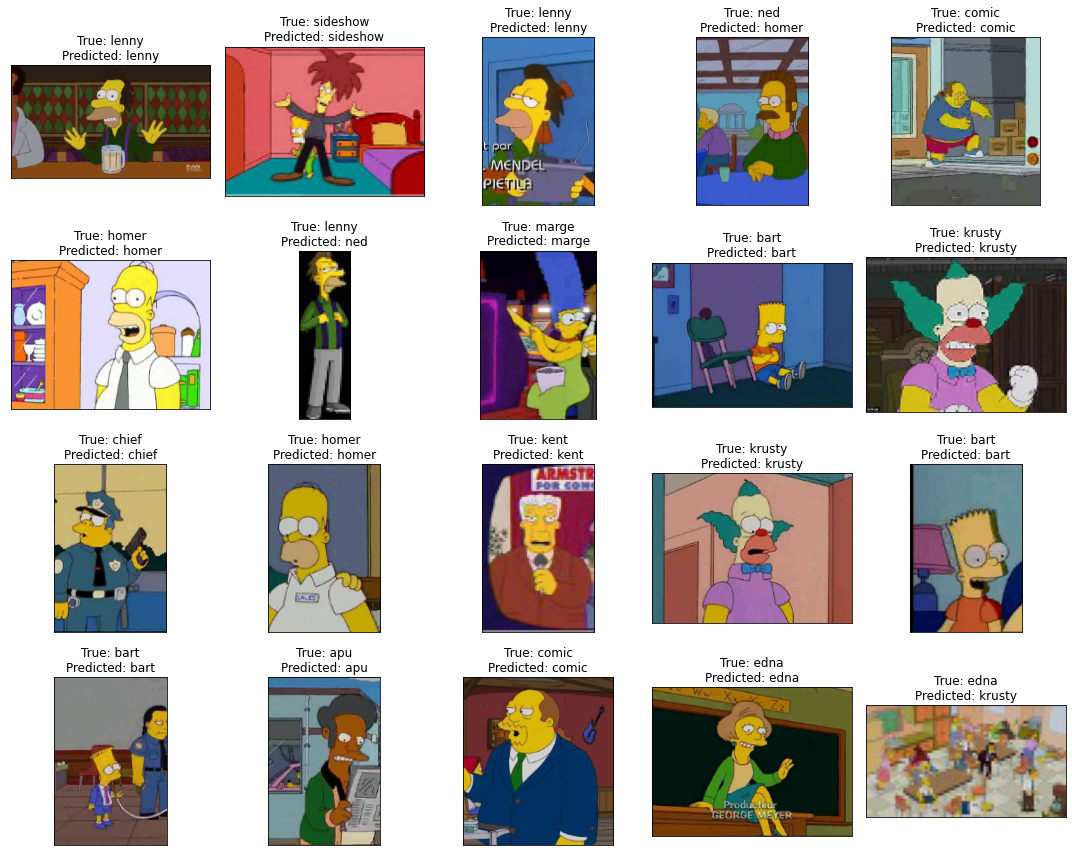

In [26]:
# Se muestran algunos resultados de la predicción
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_test.Filepath.iloc[i]))
    ax.set_title(f"True: {df_test.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}")
plt.tight_layout()
plt.show()

In [30]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [31]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 15639 validated image filenames belonging to 20 classes.
Found 3909 validated image filenames belonging to 20 classes.
Found 990 validated image filenames belonging to 20 classes.


In [32]:
inputs = modelo_efficientnetb0.input

x = tf.keras.layers.Dense(128, activation='relu')(modelo_efficientnetb0.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(20, activation='softmax')(x)

model_efficientnet = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model_efficientnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_efficientnet = model_efficientnet.fit(train_images, validation_data=val_images, epochs=10, batch_size=50, callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
])
model.summary()

Epoch 1/10
489/489 [==============================] - 676s 1s/step - loss: 1.3574 - accuracy: 0.6078 - val_loss: 0.8604 - val_accuracy: 0.7426
Epoch 2/10
489/489 [==============================] - 670s 1s/step - loss: 0.6767 - accuracy: 0.8058 - val_loss: 0.6239 - val_accuracy: 0.8184
Epoch 3/10
489/489 [==============================] - 671s 1s/step - loss: 0.5118 - accuracy: 0.8506 - val_loss: 0.5865 - val_accuracy: 0.8306
Epoch 4/10
489/489 [==============================] - 670s 1s/step - loss: 0.4120 - accuracy: 0.8810 - val_loss: 0.6452 - val_accuracy: 0.8168
Epoch 5/10
489/489 [==============================] - 671s 1s/step - loss: 0.3432 - accuracy: 0.8959 - val_loss: 0.5726 - val_accuracy: 0.8396
Epoch 6/10
489/489 [==============================] - 671s 1s/step - loss: 0.2798 - accuracy: 0.9163 - val_loss: 0.5762 - val_accuracy: 0.8416
Epoch 7/10
489/489 [==============================] - 671s 1s/step - loss: 0.2504 - accuracy: 0.9234 - val_loss: 0.6024 - val_accuracy: 0.8358

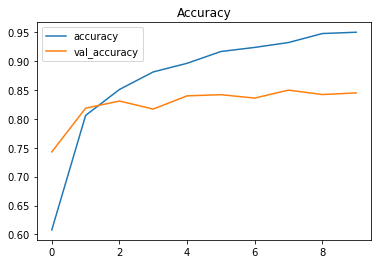

In [33]:
pd.DataFrame(history_efficientnet.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

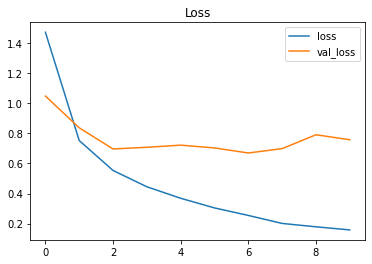

In [34]:
pd.DataFrame(history_resnet50.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [39]:
# Se hace la predicción con el conjunto de test
pred = model_efficientnet.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Se muestran los resultados
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['sideshow_bob', 'sideshow_bob', 'lenny_leonard', 'ned_flanders', 'comic_book_guy']


In [40]:
from sklearn import metrics
y_test = list(df_test.Label)
acc = metrics.accuracy_score(y_test,pred)
print(f'Accuracy en el conjunto de prueba: {acc * 100:.2f}%')

Accuracy en el conjunto de prueba: 86.46%


In [41]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.76      0.94      0.84        48
  apu_nahasapeemapetilon       0.92      0.96      0.94        50
            bart_simpson       0.81      0.84      0.82        50
charles_montgomery_burns       0.92      0.73      0.81        48
            chief_wiggum       0.98      0.92      0.95        50
          comic_book_guy       0.97      0.78      0.86        49
          edna_krabappel       0.89      0.82      0.85        50
           homer_simpson       0.57      0.90      0.70        50
           kent_brockman       0.98      0.86      0.91        50
        krusty_the_clown       0.89      0.94      0.91        50
           lenny_leonard       1.00      0.68      0.81        50
            lisa_simpson       0.89      0.80      0.84        50
           marge_simpson       0.89      0.94      0.91        50
            mayor_quimby       1.00      0.80      0.89        50
     milh

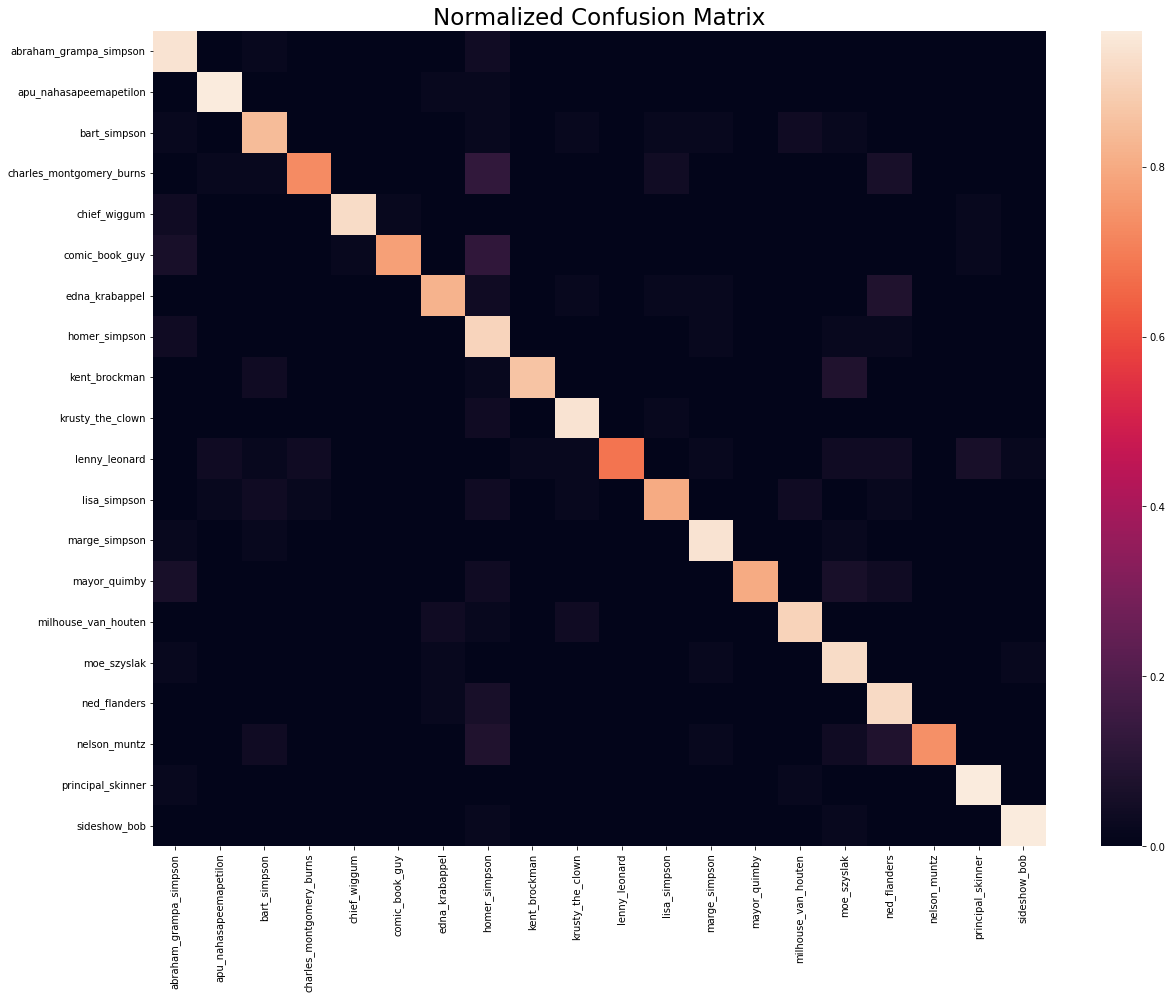

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.show()

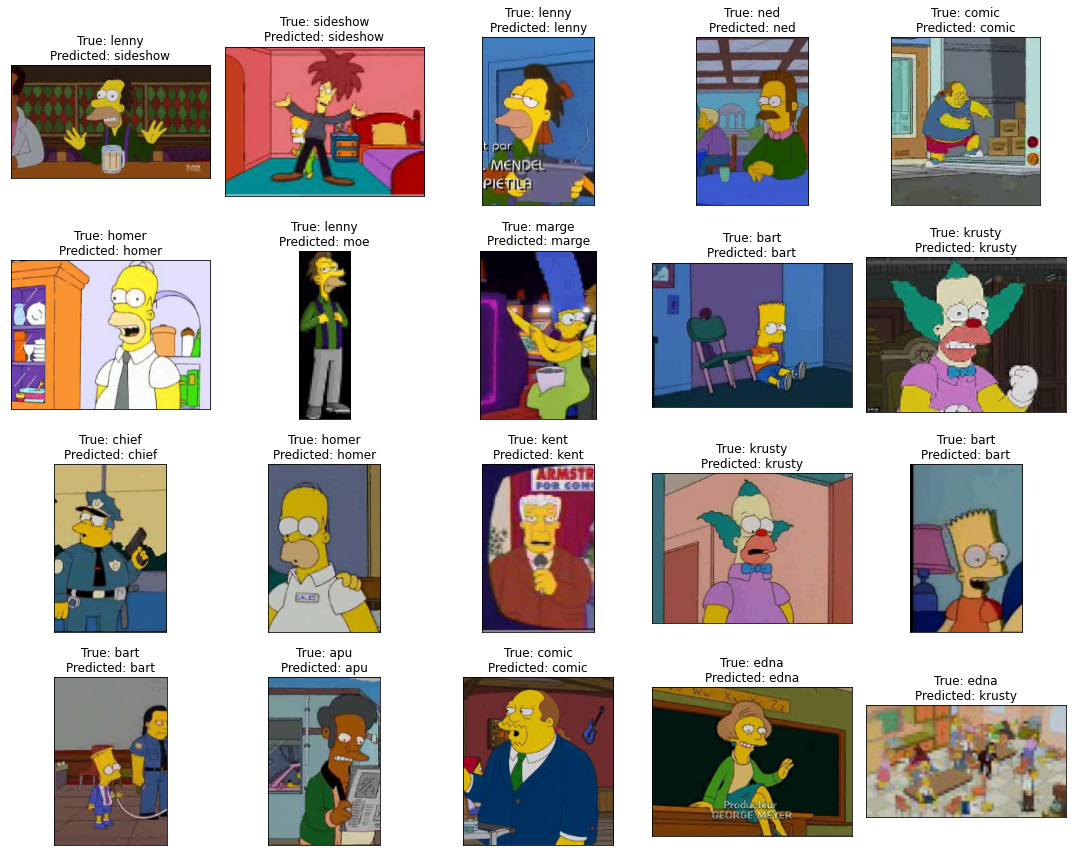

In [43]:
# Se muestran algunos resultados de la predicción
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_test.Filepath.iloc[i]))
    ax.set_title(f"True: {df_test.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}")
plt.tight_layout()
plt.show()